Run tensor cell2cell on outputs of various communication scoring tools

env name: cci_dt


In [1]:
import os
import warnings
warnings.simplefilter('ignore')
from collections import OrderedDict
from tqdm import tqdm
import itertools
import numpy as np
import pandas as pd

import cell2cell as c2c

seed = 888
np.random.seed(seed)

rev_path = '/data3/hratch/tc2c_analyses_1/natcomm_revisions/'
scores_path = rev_path + 'interim/tc2c_external_inputs/liana/liana_outputs/'

cp_delim = '-'
lr_delim = '^'

In [2]:
c2c.__version__

'0.5.9'

In [3]:
import sys
sys.path.insert(1, '/home/hratch/Projects/CCC/tc2c_analyses_1/notebooks/natcomm_revisions/')
from utility import edgelist_to_communication_matrix, matrix_to_interaction_tensor
from corrindex import correlation_index

In [4]:
score_methods = {file_name.split('_')[-1].split('.csv')[0] for file_name in os.listdir(scores_path)}
samples = {file_name.split('_')[0] for file_name in os.listdir(scores_path)}

# Generate Tensor for Each Method

In [5]:
# map the method-specific column names for the edge list
score_labels = {'natmi': {'score': 'edge_specificity', 
                            'sender': 'source', 'receiver': 'target', 
                            'ligand': 'ligand.complex', 'receptor': 'receptor.complex'}, 
               'cellchat': {'score': 'prob', 
                            'sender': 'source', 'receiver': 'target', 
                            'ligand': 'ligand', 'receptor': 'receptor'}, 
               'cellphonedb': {'score': 'lr.mean', 
                            'sender': 'source', 'receiver': 'target', 
                            'ligand': 'ligand.complex', 'receptor': 'receptor.complex'}, 
               'sca': {'score': 'LRscore', 
                            'sender': 'source', 'receiver': 'target', 
                            'ligand': 'ligand.complex', 'receptor': 'receptor.complex'}
               }
#                'connectome': {'score': 'weight_sc', 
#                             'sender': 'source', 'receiver': 'target', 
#                             'ligand': 'ligand.complex', 'receptor': 'receptor.complex'}, 
#                'logfc': {'score': 'logfc_comb', 
#                             'sender': 'source', 'receiver': 'target', 
#                             'ligand': 'ligand.complex', 'receptor': 'receptor.complex'}}

In [6]:
def drop_redundant_complexes(edge_list, score_method):
    """some complexes generated redundant rows due to distinct ligands or receptors
    double check that the communication score is the same b/w redundant complex rows
    then drop those duplicated scores."""
    
    dup_cols = list(score_labels[score_method].values())
    dup_cols.remove(score_labels[score_method]['score'])
    dup_idx = edge_list[edge_list[dup_cols].duplicated(subset = dup_cols)].index.tolist()

    for i in dup_idx:
        dup_val = edge_list.loc[i, dup_cols]
        unique_scores = edge_list[(edge_list[dup_cols[0]] == dup_val.loc[dup_cols[0]]) & 
                 (edge_list[dup_cols[1]] == dup_val.loc[dup_cols[1]]) & 
                 (edge_list[dup_cols[2]] == dup_val.loc[dup_cols[2]]) & 
                 (edge_list[dup_cols[3]] == dup_val.loc[dup_cols[3]])][score_labels[score_method]['score']].unique()
        if len(unique_scores) > 1:
            raise ValueError('Unexpected inconsistency in communication scores b/w complexs')


    el = edge_list.drop_duplicates(subset = dup_cols) 
    return el

In [7]:
# convert LIANA edgelist to communication matrix format for all contexts/methods
score_matrices = dict()

for score_method in score_methods:
    for sample in samples:
        edge_list = pd.read_csv(scores_path + ''.join([sample, '_communication_scores_', score_method, '.csv']))
        edge_list = drop_redundant_complexes(edge_list, score_method)


        cm = edgelist_to_communication_matrix(edge_list, 
                                        score_col = score_labels[score_method]['score'], 
                                        sender_cell_col = score_labels[score_method]['sender'], 
                                        receiver_cell_col = score_labels[score_method]['receiver'], 
                                        ligand_col = score_labels[score_method]['ligand'], 
                                        receptor_col = score_labels[score_method]['receptor'], 
                                             fillna_val=0) # fill missing values with 0
        if score_method in score_matrices:
            score_matrices[score_method][sample] = cm
        else:
            score_matrices[score_method] = {sample: cm}

In [8]:
tensors = {}
for method, scores in score_matrices.items():
    tensors[method] = matrix_to_interaction_tensor(scores=scores, 
                             lr_how = 'inner', cell_how='inner')

100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


In [9]:
tensors.keys()

dict_keys(['cellchat', 'natmi', 'sca', 'cellphonedb'])

In [10]:
[tensor.tensor.shape for tensor in tensors.values()] # context, LR, sender cell, receiver cell

[(12, 226, 6, 6), (12, 272, 6, 6), (12, 272, 6, 6), (12, 272, 6, 6)]

In [11]:
# take inner across all tensors to have consistent comparisons
# and order the indeces
context_order = ['C51', 'C52', 'C100', 'C141', 'C142', 'C144', 'C145', 'C143', 'C146', 'C148', 'C149', 'C152']

# add the cell2cell tensors
# match formatting of other tensors
c2c_tensor = c2c.io.load_variable_with_pickle(rev_path + 'processed/Tensor-BALF.pkl')
c2c_tensor.order_names[0] = context_order 
c2c_tensor.order_names[1] = ['_'.join(lr.split('&')) for lr in c2c_tensor.order_names[1]] # match liana formatting (complexes joing by _ rather than &)
print('The cell2cell tensor shape is: ')
print(c2c_tensor.tensor.shape)
tensors['cell2cell'] = c2c_tensor

inner_lr = set.intersection(*map(set,[tensor.order_names[1] for tensor in tensors.values()]))
inner_cells = set.intersection(*map(set,[tensor.order_names[2] for tensor in tensors.values()]))

for method, tensor in tensors.items():
    tensors[method] = c2c.tensor.subset_tensor(interaction_tensor = tensor, 
                                     subset_dict = {0: context_order, 
                                                    1: sorted(inner_lr), 
                                                   2: sorted(inner_cells), 
                                                   3: sorted(inner_cells)}, 
                                   original_order=False)

The cell2cell tensor shape is: 
(12, 189, 6, 6)


In [12]:
tensors.keys()

dict_keys(['cellchat', 'natmi', 'sca', 'cellphonedb', 'cell2cell'])

In [13]:
print('After taking the LR and cell types common across all tools: ')
[tensor.tensor.shape for tensor in tensors.values()]

After taking the LR and cell types common across all tools: 


[(12, 172, 6, 6),
 (12, 172, 6, 6),
 (12, 172, 6, 6),
 (12, 172, 6, 6),
 (12, 172, 6, 6)]

# Run decomposition

In [15]:
rank = 10 # same tensor rank as in original BALF
for method, tensor in tqdm(tensors.items()):
    tensor.compute_tensor_factorization(rank=rank,
                                        init='svd',
                                        var_ordered_factors = False,
                                        random_state=seed)

100%|██████████| 5/5 [01:19<00:00, 15.90s/it]


# Calculate CorrIndex
assess consistency between decompositions

In [16]:
corrindex_df = pd.DataFrame(columns = tensors.keys(), index = tensors.keys()) # initialize

In [17]:
for method_1 in corrindex_df.index:
    for method_2 in corrindex_df.columns:
        corrindex_df.loc[method_1, method_2] = correlation_index(list(tensors[method_1].factors.values()), 
                                                        list(tensors[method_2].factors.values()), 
                                                                method = 'max_score')

In [18]:
corrindex_df

,cellchat,natmi,sca,cellphonedb,cell2cell
cellchat,0,0.615927,0.412228,0.397097,0.402552
natmi,0.615927,0,0.328983,0.378576,0.378826
sca,0.412228,0.328983,0,0.239939,0.203697
cellphonedb,0.397097,0.378576,0.239939,0,0.072321
cell2cell,0.402552,0.378826,0.203697,0.072321,0


In [ ]:
# output_dir = rev_path + 'figures/'
# cm = c2c.plotting.clustermap_cci(corrindex_df,
#                                  method='ward',
#                                  optimal_leaf=True,
#                                  metadata=None,
#                                  title='',
#                                  cbar_title='CorrIndex', 
#                                  cmap='Blues_r',
#                                  vmax=1.,
#                                  vmin=0.,
#                                  annot=True)

# font = matplotlib.font_manager.FontProperties(family='arial', weight='bold', size=14)
# for ax in [cm.ax_heatmap, cm.ax_cbar]:
#     for tick in ax.get_xticklabels():
#         tick.set_fontproperties(font)
#     for tick in ax.get_yticklabels():
#         tick.set_fontproperties(font)

#     text = ax.yaxis.label
#     text.set_font_properties(font)
    
# plt.savefig(os.path.join(output_dir, 'CorrIndex_methods.png'),
#             dpi=600, 
#             bbox_inches='tight',
#             edgecolor='none')

# Visualize each decomposition

In [19]:
# generate metadata
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
lr_pairs['ligand2'] = lr_pairs.interaction_name_2.apply(lambda x: x.split(' - ')[0].upper())
lr_pairs['receptor2'] = lr_pairs.interaction_name_2.apply(lambda x: x.split(' - ')[1].upper() \
                                                       .replace('(', '').replace(')', '').replace('+', '&'))
lr_pairs['c2c_interaction'] = lr_pairs.apply(lambda row: row['ligand2'] + '^' + row['receptor2'], axis=1)
int_cols = ('ligand2', 'receptor2')
lr_pairs = c2c.preprocessing.ppi.remove_ppi_bidirectionality(ppi_data=lr_pairs, 
                                                             interaction_columns=int_cols
                                                            )

ppi_functions = dict()
for idx, row in lr_pairs.iterrows():
    ligand = row[int_cols[0]]
    receptor = row[int_cols[1]]
    ppi_label = ligand.replace('&', '_') + '^' + receptor.replace('&', '_')
    ppi_functions[ppi_label] = row['annotation']
    
sample_disease = dict(zip(context_order, 
                         ['Control']*3 + ['Moderate COVID-19']*3 + ['Severe COVID-19']*6))

Removing bidirectionality of PPI network


In [20]:
meta_tfs = {method: c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[sample_disease, ppi_functions, None, None],
                                              fill_with_order_elements=True
                                             ) for method,tensor in tensors.items()}

In [21]:
cmaps = ['plasma', 'Dark2_r', 'tab20', 'tab20']

  0%|          | 0/5 [00:00<?, ?it/s]

cellchat


 20%|██        | 1/5 [00:20<01:22, 20.51s/it]

natmi


 40%|████      | 2/5 [00:36<00:53, 17.74s/it]

sca


 60%|██████    | 3/5 [00:52<00:33, 16.91s/it]

cellphonedb


 80%|████████  | 4/5 [01:07<00:16, 16.33s/it]

cell2cell


100%|██████████| 5/5 [01:24<00:00, 16.86s/it]


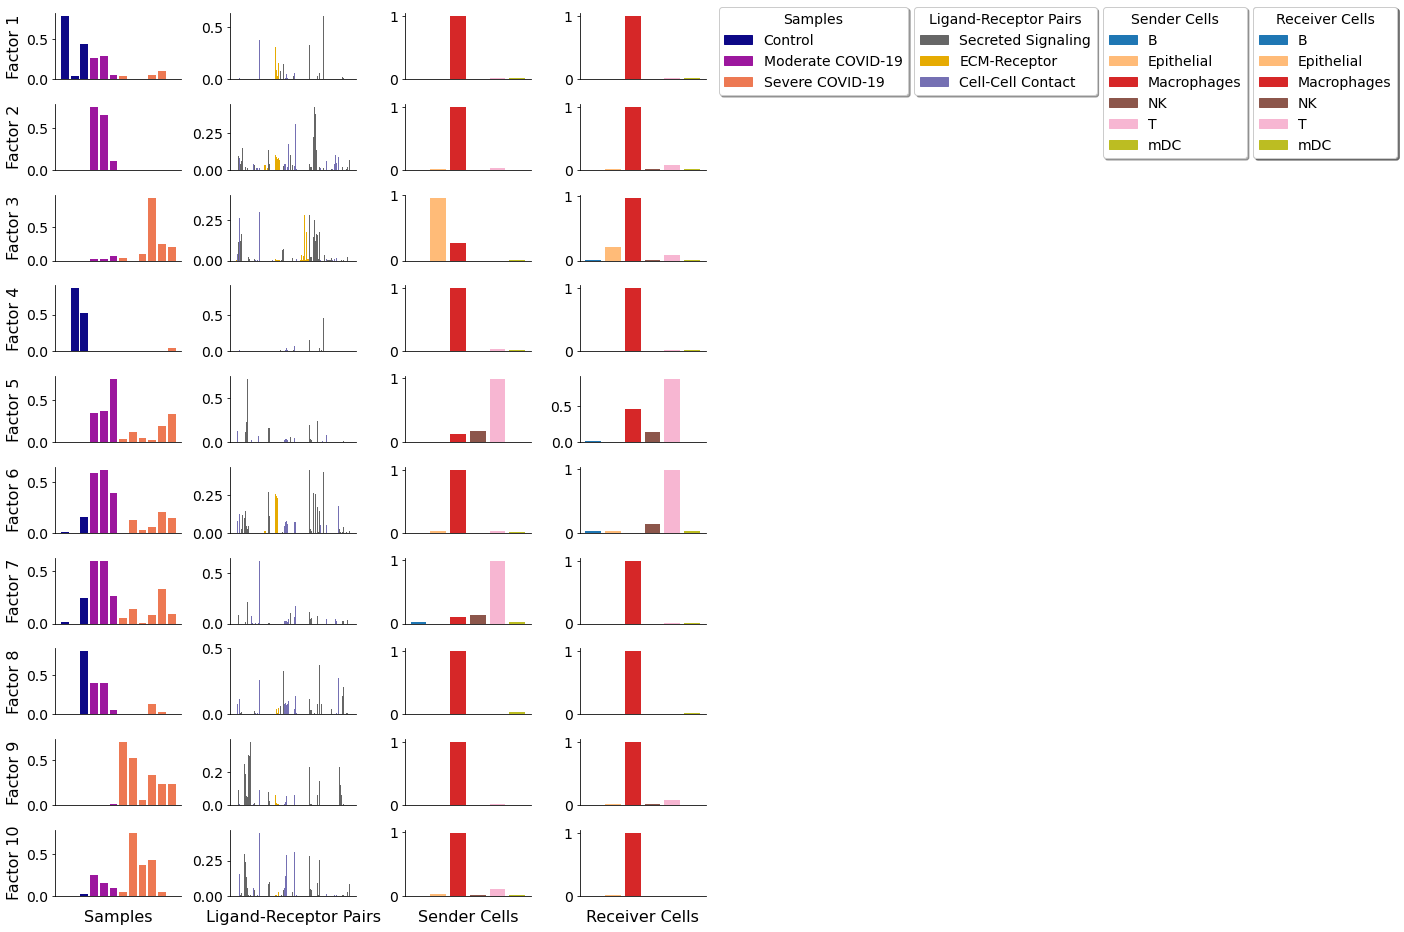

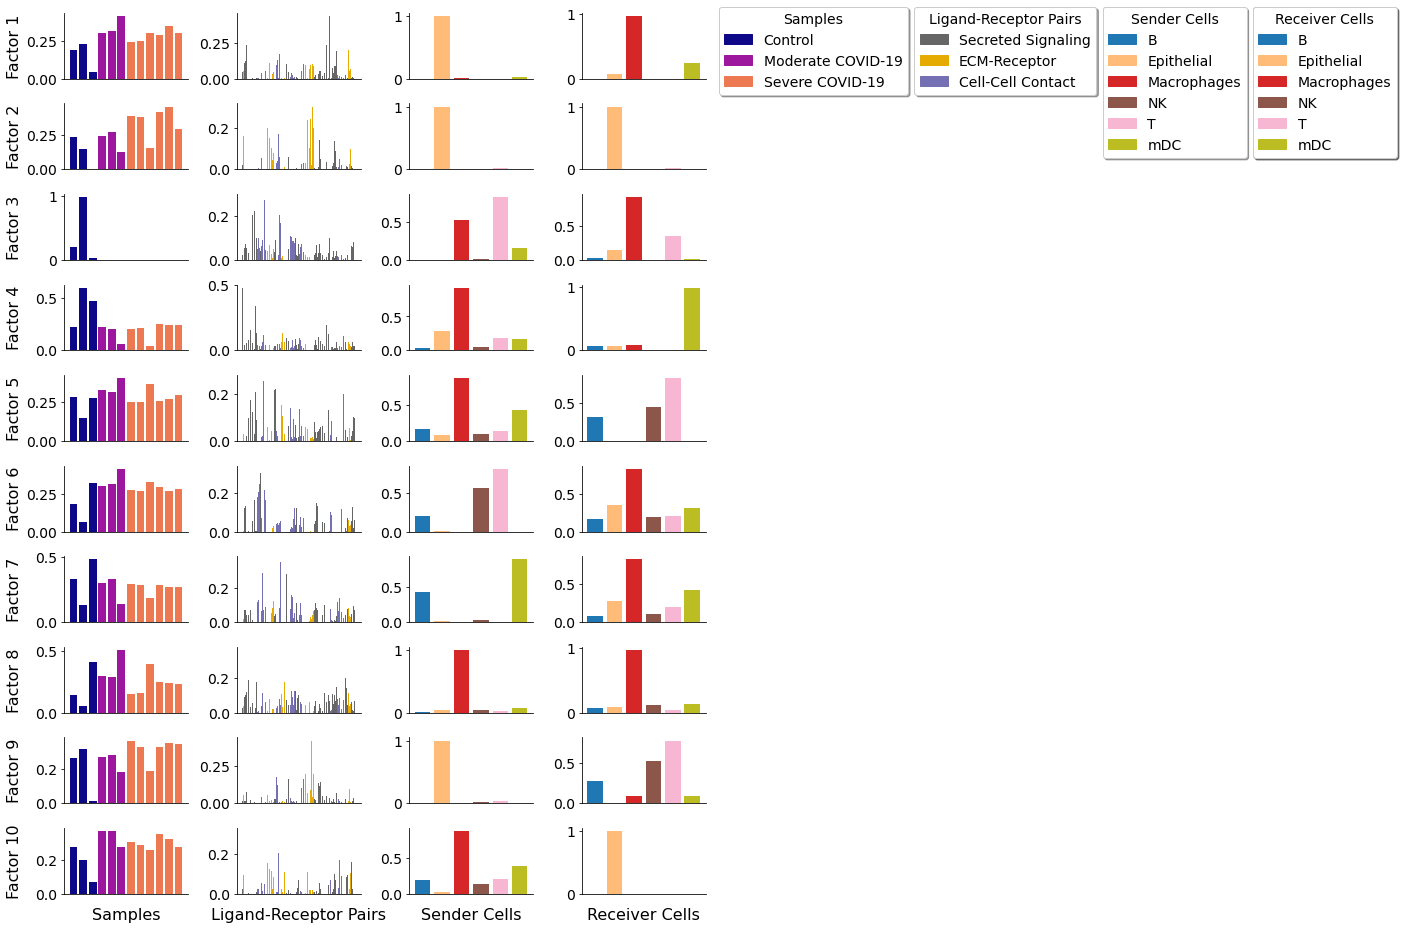

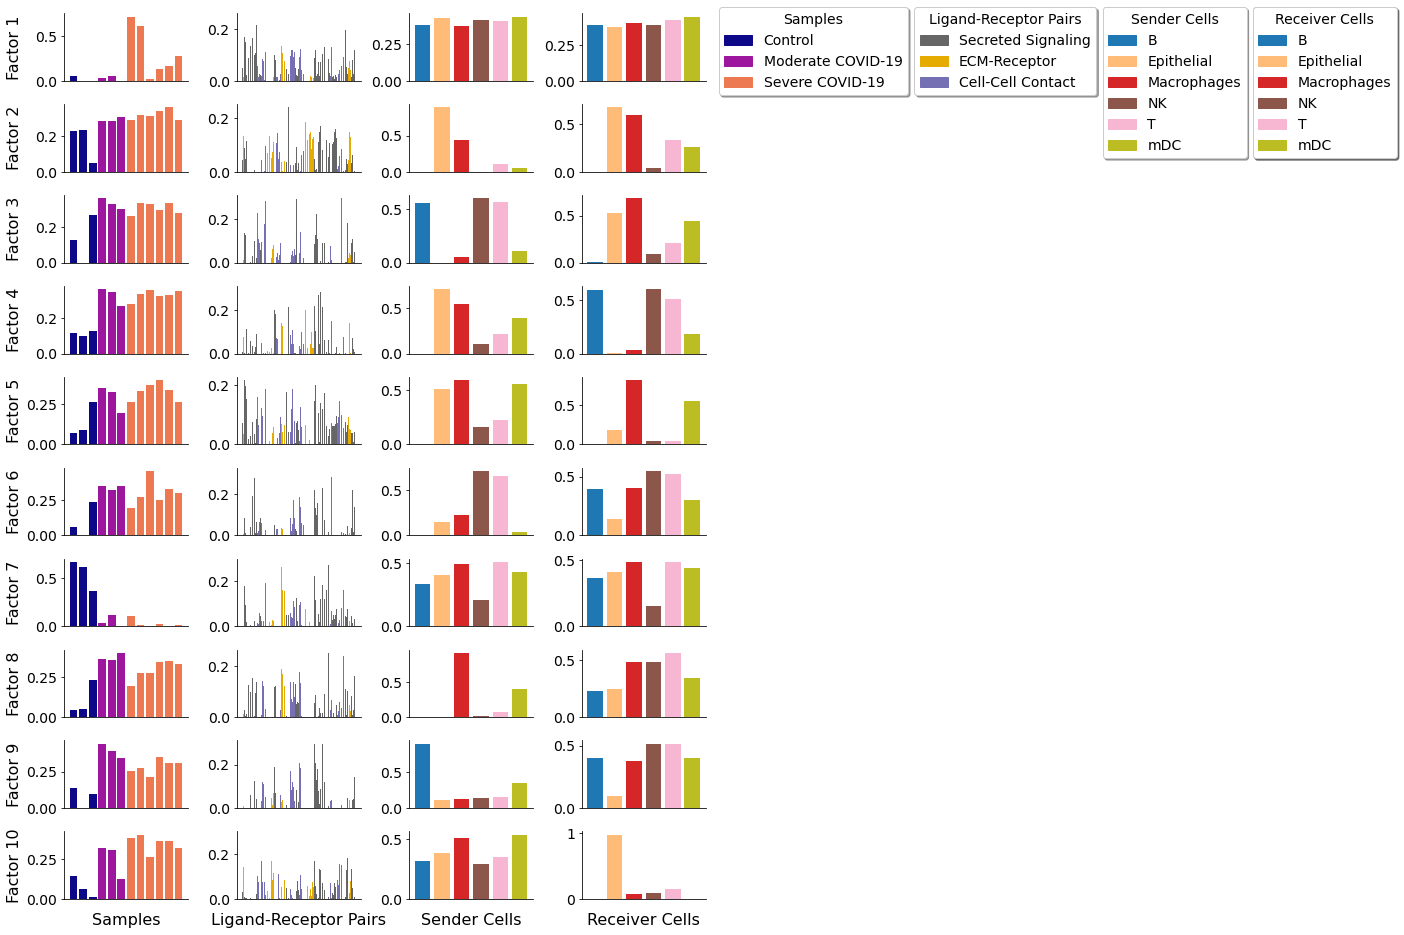

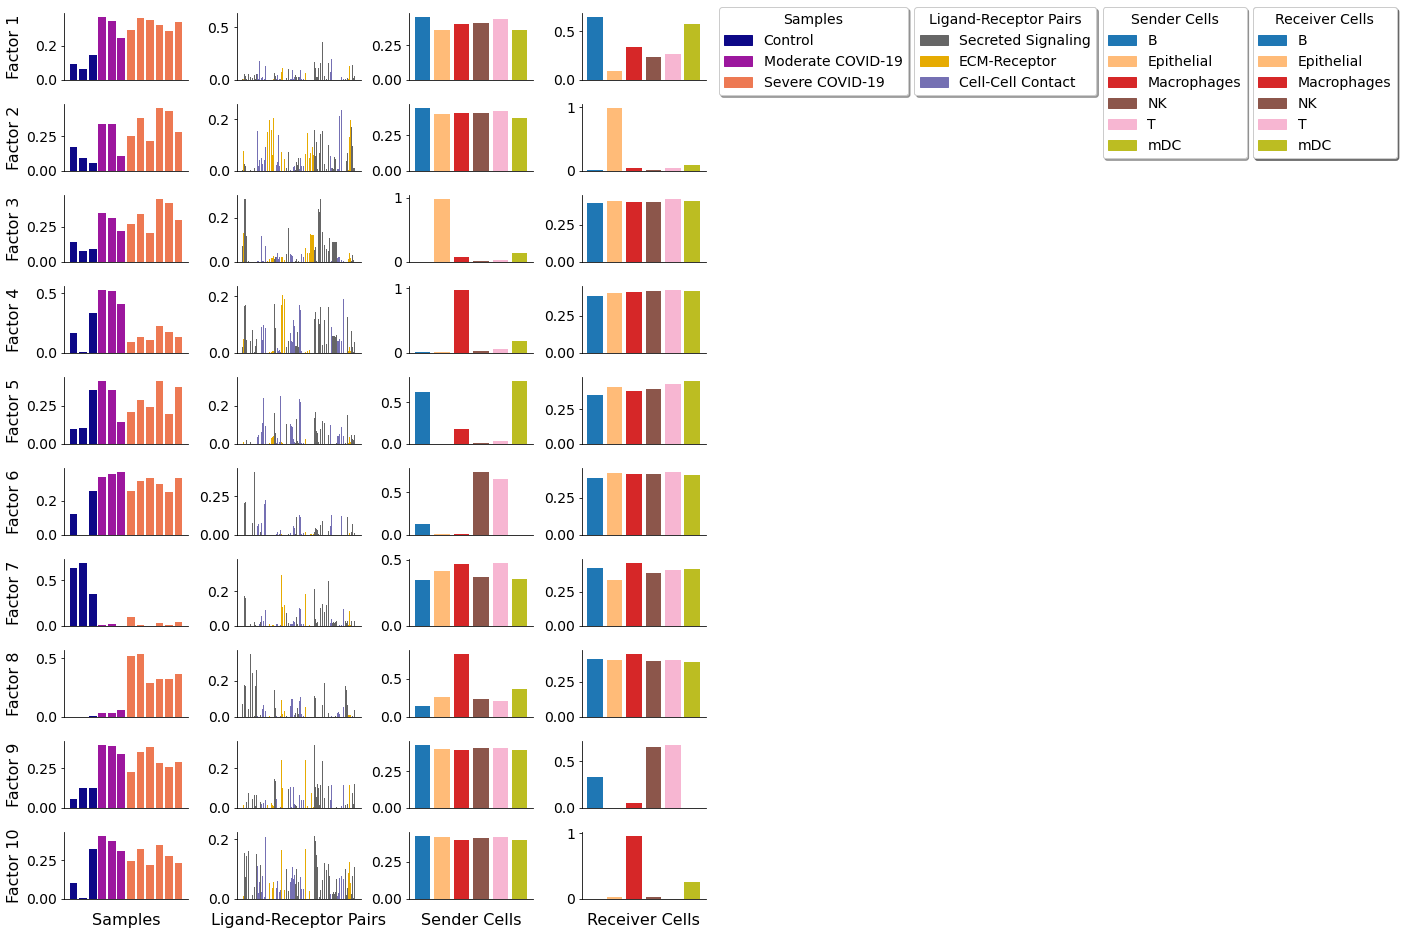

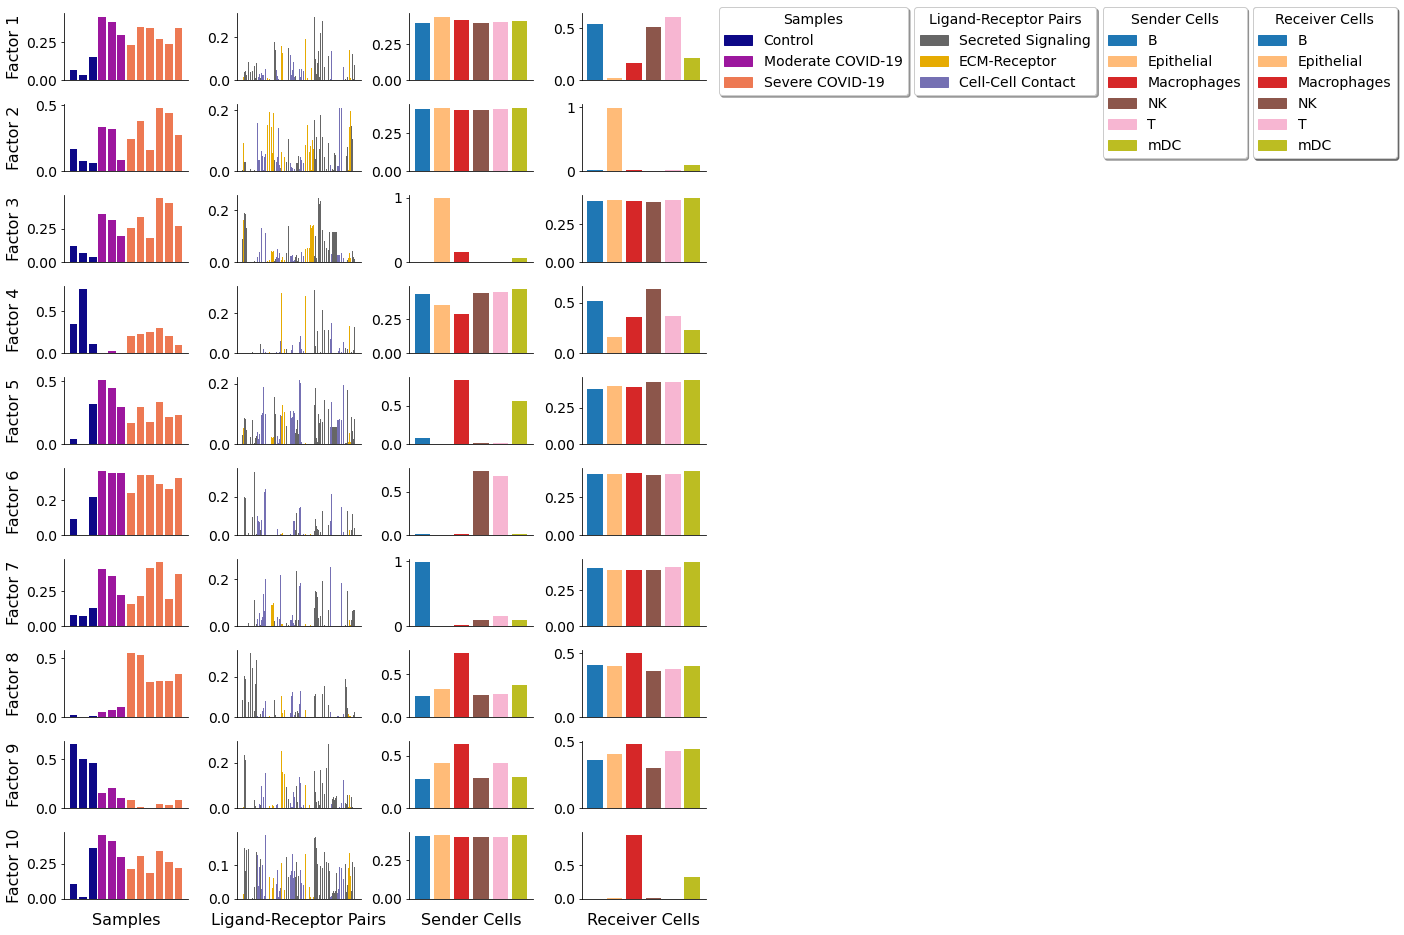

In [22]:
output_folder = rev_path + 'figures/'
for method, tensor in tqdm(tensors.items()):
    print(method)
    fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensors[method],
                                                 order_labels=['Samples', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'],
                                                 metadata = meta_tfs[method],
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps=cmaps,
                                                 fontsize=14,
                                                 filename=output_folder + '/' + method + '_factorization.png'
                                                )